# 1. Defining Necessary Libraries and Data Paths


In this section, we define the essential libraries and the training/testing data paths.

In [1]:
#Required Libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
from pathlib import Path

#Data Paths
train_path = Path("../input/car-object-detection/data/training_images")
test_path = Path("../input/car-object-detection/data/testing_images")


# 2. Loading and Preprocessing the Training Data

In [2]:
# Load the training data
train = pd.read_csv("../input/car-object-detection/data/train_solution_bounding_boxes (1).csv")

# Convert bounding box coordinates to integers
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)

# Remove duplicate rows for individual images
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)


In this step, we load the train.csv file, adjust the bounding box coordinates, and remove duplicate entries.

# 3. Image and Bounding Box Visualization Functions


In [3]:
# Functions for Visualizing Images and Bounding Boxes
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path / name))
    display_image(img, bbox_coords=bbox_coords)

def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])


These functions:

    Display the image on the screen.
    Draw bounding boxes to annotate the images.
    Display multiple random images in a grid layout.

# 4. Defining the Sharpening Filter



In [4]:
# Sharpening filter
def apply_sharpening(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    sharpened = cv2.filter2D(img, -1, kernel)
    return sharpened


This filter sharpens images and makes them clearer.

# 5. Data Generator



In [5]:
# Data Generator
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        for i in range(batch_size):
            rand_index = np.random.randint(0, train.shape[0])
            row = df.loc[rand_index, :]
            img = cv2.imread(str(path / row.image)) / 255.0
            img = apply_sharpening(img)  # Sharpening uygula
            images[i] = img
            bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
        yield {'image': images}, {'coords': bounding_box_coords}


This generator:

    Selects random images.
    Applies the sharpening filter.
    Produces data for model training.

# 6. Model Creation


In [6]:
# Model Creation
input_ = Input(shape=[380, 676, 3], name='image')
x = input_
for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.compile(
    loss={'coords': 'mse'},
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={'coords': 'accuracy'}  # Accuracy
)



This is a convolutional neural network that will predict bounding box coordinates.

# 7. Testing the Model

In [7]:
# Test Functions
def test_model(model, datagen):
    example, label = next(datagen)
    X = example['image']
    y = label['coords']
    pred_bbox = model.predict(X)[0]
    img = X[0]
    gt_coords = y[0]
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    plt.figure(figsize=(15, 7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)


These functions test the model's accuracy and display the predicted bounding boxes.

# 8. Training and Analyzing the Model


Epoch 1/5
500/500 [==============================] - 156s 296ms/step - loss: 5125.4551 - accuracy: 0.8518


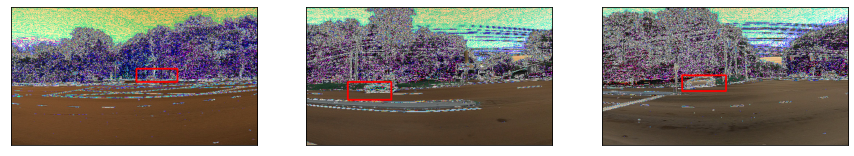

Epoch 2/5
500/500 [==============================] - 147s 295ms/step - loss: 906.6864 - accuracy: 0.9676


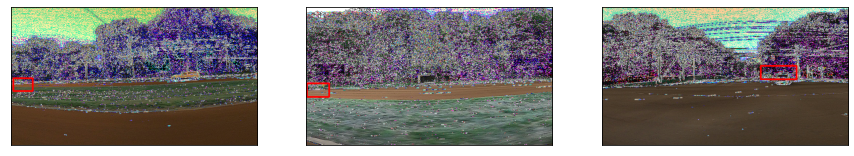

Epoch 3/5
500/500 [==============================] - 146s 292ms/step - loss: 373.4755 - accuracy: 0.9761


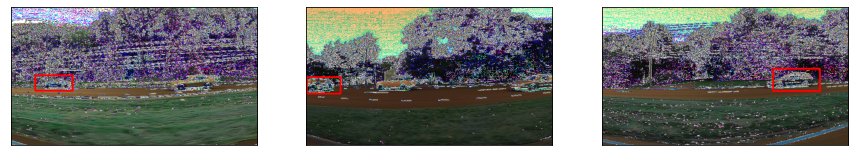

Epoch 4/5
500/500 [==============================] - 146s 293ms/step - loss: 1022.1558 - accuracy: 0.9603


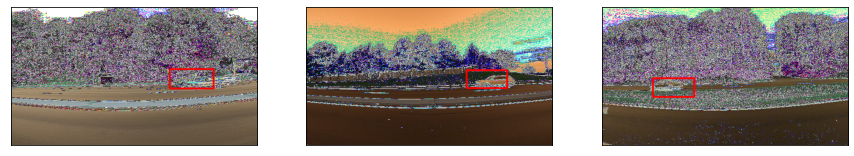

Epoch 5/5
143/500 [=======>......................] - ETA: 1:42 - loss: 289.4064 - accuracy: 0.9777

In [ ]:
# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
        data_generator(),
        epochs=5,
        steps_per_epoch=500,
        callbacks=[ShowTestImages()]
    )


# Save the model
model.save('car-object-detection-sharpened.h5')
